# Movie Recommender

An attempt to build a movie recommender that can recommend movies by popularity, content, collaborative filtering (analyzing a user's past behaviour), and by matrix factorization (generating latent features from available data).

The dataset in use is the [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/).


# Load Data

In [70]:
!pip install surprise

In [71]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Your file path here
FILE_PATH = '/content/drive/MyDrive/ML/GBC/ML2/Assignments/ml-20m/'

RANDOM_STATE = 42

In [72]:
movies = pd.read_csv(FILE_PATH + "movies.csv")
print(movies.shape)
movies.head(5)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [73]:
# check for null data
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [74]:
# Load ratings
ratings = pd.read_csv(FILE_PATH + "ratings.csv")
print(ratings.shape)
ratings.head(5)

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [75]:
# check for null data
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [76]:
tags = pd.read_csv(FILE_PATH + "tags.csv")
print(tags.shape)
tags.head(5)

(465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [77]:
# These will need to be one hot encoded, vectorized, etc...
len(tags.tag.unique())

38644

In [78]:
# check for null data
print(tags.tag.isna().sum() , 'tags missing out of' , tags.tag.count(), 'rows')
tags.isna().sum()

16 tags missing out of 465548 rows


userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [79]:
# 16 rows with missing data out of 465548 isn't so bad. Let's avoid extrapolating, and just drop them...
tags.dropna(subset=['tag'], inplace=True)
print(tags.tag.isna().sum() , 'tags missing out of' , tags.tag.count(), 'rows')

0 tags missing out of 465548 rows


Here, we take a sample of data due to memory limitations. It's a really big dataset! Unfortunately this will impact the number of movies we can add to our recommender, but fortunely the amount of data will be useable within a Google Colab instance.

In [80]:
movies = movies.sample(frac=0.2, random_state=RANDOM_STATE)
movies.head()

,movieId,title,genres
12922,61116,Black Caesar (1973),Crime|Drama
14085,70697,G-Force (2009),Action|Adventure|Children|Fantasy
23517,111931,Raze (2013),Action|Horror
8960,26630,Moonwalker (1988),Musical
13152,63692,Don Q Son of Zorro (1925),Adventure|Romance


In [81]:
# Take a subsample of tags and ratings per movie (further avoidance of memory limitations)
movies_with_missing_data = []
tags_trimmed = pd.DataFrame()
ratings_trimmed = pd.DataFrame()

for index, row in movies.iterrows():
  movie_id = row['movieId']
  rating_count = len(tags.loc[tags['movieId'] == movie_id])
  tag_count = len(ratings.loc[ratings['movieId'] == movie_id])
  if rating_count > 0 and tag_count > 0:
    culled_tags = tags.loc[tags['movieId'] == movie_id][:20]
    culled_ratings = ratings.loc[ratings['movieId'] == movie_id][:15]

    tags_trimmed = tags_trimmed.append(culled_tags)
    ratings_trimmed = ratings_trimmed.append(culled_ratings)
  else:
    movies_with_missing_data.append(movie_id)

In [82]:
print(movies.shape[0])
movies_trimmed = movies[~movies['movieId'].isin(movies_with_missing_data)]
print(movies_trimmed.shape[0])
print(len(tags_trimmed['movieId'].unique()))
print(len(tags_trimmed['movieId'].unique()))

5456
3818
3818
3818


# Preprocess Data

In [83]:
ps = PorterStemmer()
tags_trimmed.tag = tags_trimmed.tag.apply(lambda x: ps.stem(re.sub(r'[^\w\s]','',x).lower()))

len(tags_trimmed.tag.unique())

8813

In [84]:
# clean other data
movies_trimmed.genres = movies_trimmed.genres.apply(lambda x: x.replace('|', ','))

tags_trimmed = tags_trimmed.drop(['timestamp'], axis=1)
ratings_trimmed = ratings_trimmed.drop(['timestamp'], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# TF-IDF Vectorizer on Metadata

In [85]:
movies_with_all_tags = pd.merge(movies_trimmed, tags_trimmed, on='movieId')
movies_with_all_tags = movies_with_all_tags.drop(['userId'], axis=1)
movies_with_all_tags = movies_with_all_tags.drop_duplicates()
movies_with_all_tags = movies_with_all_tags.groupby('movieId').agg({
  'tag': lambda x: ', '.join(x)
})
movies_with_all_tags = pd.merge(movies_trimmed, movies_with_all_tags, on='movieId')
movies_with_all_tags.head()

,movieId,title,genres,tag
0,61116,Black Caesar (1973),"Crime,Drama",blaxploit
1,70697,G-Force (2009),"Action,Adventure,Children,Fantasy","business is the antagonist, talking anim, anim..."
2,26630,Moonwalker (1988),Musical,"michael jackson, music, surreal, not available..."
3,63692,Don Q Son of Zorro (1925),"Adventure,Romance","donald crisp, dvdvideo"
4,67459,Chaos (2005),"Crime,Drama,Horror",rape


In [86]:
tfidf = TfidfVectorizer(stop_words = "english")

In [87]:
tfidf_genre_matrix = tfidf.fit_transform(movies_with_all_tags['genres'])
tfidf_genre_matrix = pd.DataFrame(tfidf_genre_matrix.toarray(), index = movies_trimmed.index.tolist())
tfidf_genre_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
12922,0.000000,0.000000,0.0,0.000000,0.000000,0.883692,0.0,0.468069,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
14085,0.420435,0.460072,0.0,0.573134,0.000000,0.000000,0.0,0.000000,0.532058,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
8960,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
13152,0.000000,0.759347,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.650686,0.0,0.0,0.000000,0.0
13572,0.000000,0.000000,0.0,0.000000,0.000000,0.653234,0.0,0.346001,0.000000,0.0,0.0,0.0,0.673475,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22507,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.519647,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.854381,0.0,0.0,0.000000,0.0
12643,0.000000,0.000000,0.0,0.000000,0.515706,0.757117,0.0,0.401025,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
21617,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
26310,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [88]:
# get tfidf matrix of tags - but then incrememnt the col IDs to combine with the genre matrix
tfidf_tag_matrix = tfidf.fit_transform(movies_with_all_tags['tag'])
tfidf_tag_matrix = pd.DataFrame(data=tfidf_tag_matrix.toarray(), index=movies_trimmed.index.tolist())
numCols = tfidf_tag_matrix.shape[1]
columns = [x+22 for x in range(1,numCols+1)]
tfidf_tag_matrix.columns = columns
tfidf_tag_matrix

,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,...,8761,8762,8763,8764,8765,8766,8767,8768,8769,8770,8771,8772,8773,8774,8775,8776,8777,8778,8779,8780,8781,8782,8783,8784,8785,8786,8787,8788,8789,8790,8791,8792,8793,8794,8795,8796,8797,8798,8799,8800
12922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Create one dataframe with all the metadata - both genres and tags
movies_with_metadata = movies_with_all_tags
movies_with_metadata = movies_with_metadata.drop(['genres', 'tag', 'movieId'], axis=1)
movies_with_metadata = movies_with_metadata.join(tfidf_genre_matrix).fillna(0)
movies_with_metadata = movies_with_metadata.join(tfidf_tag_matrix).fillna(0)
movies_with_metadata = movies_with_metadata.set_index('title')
movies_with_metadata.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8761,8762,8763,8764,8765,8766,8767,8768,8769,8770,8771,8772,8773,8774,8775,8776,8777,8778,8779,8780,8781,8782,8783,8784,8785,8786,8787,8788,8789,8790,8791,8792,8793,8794,8795,8796,8797,8798,8799,8800
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Black Caesar (1973),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G-Force (2009),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Moonwalker (1988),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Don Q Son of Zorro (1925),0.0,0.0,0.0,0.0,0.555611,0.0,0.0,0.432056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.710369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chaos (2005),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
movies_with_metadata.shape

(3818, 8801)

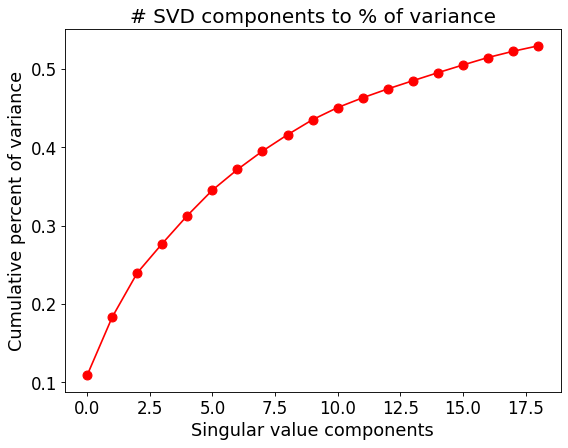

In [91]:
from matplotlib.pyplot import figure

svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(movies_with_metadata)
explained = svd.explained_variance_ratio_.cumsum()

plt.rcParams.update({'font.size': 15})
figure(figsize=(8, 6), dpi=80)

plt.title('# SVD components to % of variance', fontsize=18)
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize=16)
plt.ylabel('Cumulative percent of variance', fontsize=16)        
plt.show()

In [92]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=list(movies_with_metadata.index))

In [93]:
latent_matrix_1_df.shape

(3818, 19)

In [94]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Black Caesar (1973),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
G-Force (2009),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Moonwalker (1988),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Don Q Son of Zorro (1925),0.794735,0.345024,-0.247974,0.023032,0.483243,-0.06702,-0.061633,0.000305,-0.050311,-0.048161,0.005034,0.022816,-0.041763,-0.13161,-0.089978,0.005674,0.042546,-0.054128,0.299612
Chaos (2005),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


# Content & Collaborative Filtering 

In [95]:
svd = TruncatedSVD(n_components=19)

In [96]:
# unique_movie_ids = ratings_trimmed['movieId'].unique()
# print(len(unique_movie_ids))
# len(ratings_trimmed['movieId'].unique())

In [97]:
movie_ratings = ratings_trimmed.pivot(index="movieId", columns="userId", values="rating").fillna(0)

In [98]:
movie_ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,135828,135879,135984,136015,136053,136054,136196,136223,136240,136262,136268,136593,136599,136690,136748,136806,136819,136915,136989,137031,137200,137202,137249,137277,137280,137360,137400,137451,137675,137717,137805,137884,137942,138034,138103,138164,138177,138301,138325,138436
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,3.5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
latent_matrix_2 = svd.fit_transform(movie_ratings)

In [100]:
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=list(movies_with_metadata.index))

In [101]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Black Caesar (1973),2.085921e+00,-1.033237e+00,-6.904650e-01,-1.598658e+00,5.353122e-01,-1.138305e-01,-8.366002e-01,-5.675854e-01,-2.776114e-01,4.231797e-01,-5.277604e-02,-6.255814e-02,-3.842815e-01,-3.954070e-01,3.045284e-02,-3.439536e-01,-4.372425e-01,-1.476355e-01,1.062589e+00
G-Force (2009),1.285946e+00,-1.031608e+00,-1.691525e+00,1.313589e+00,-6.562546e-01,-7.429301e-01,1.031396e+00,1.005439e+00,-1.283158e-01,1.879132e-01,9.687771e-01,-7.246939e-02,-7.152564e-01,5.747227e-02,-2.208005e-02,6.953529e-01,1.292747e-01,5.273967e-01,-9.670659e-01
Moonwalker (1988),3.523470e+00,-2.104875e+00,-2.072167e+00,-8.424315e-01,3.333080e-01,-1.016940e+00,-5.319923e-01,-2.407220e-01,-1.937939e-01,5.870798e-01,5.106398e-01,-1.435594e-01,1.914181e-01,4.074890e-01,-4.170246e-01,2.190760e+00,2.949860e-01,8.316155e-01,-8.820402e-02
Don Q Son of Zorro (1925),1.570824e+00,-4.669277e-01,1.070222e+00,9.900649e-02,-1.655515e-01,2.148263e+00,-5.151668e-01,-1.466601e-01,-3.339170e-01,-9.534492e-01,6.200678e-01,-2.520138e-01,-5.215703e-01,3.820740e-01,-2.761488e-01,5.107542e-01,1.196032e+00,-4.230816e-01,-7.205953e-01
Chaos (2005),8.272527e-01,-6.747826e-01,-9.995066e-01,1.024313e+00,-4.177792e-01,-3.711448e-01,4.728033e-01,3.948578e-01,-1.544138e-01,6.714737e-02,1.902394e-01,-2.140853e-02,-2.971050e-01,-1.108458e-01,2.273372e-01,1.538608e-01,7.901704e-02,4.080532e-01,7.076623e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yves Saint Laurent (2014),-3.635126e-16,-8.542417e-16,1.799873e-15,2.339529e-14,3.614575e-14,-8.889933e-14,9.869709e-14,-1.085916e-12,-9.220100e-13,-2.934582e-12,-1.376312e-12,3.162698e-12,1.497365e-12,-3.028910e-12,3.697484e-12,-4.570573e-12,-6.766748e-12,-1.133516e-11,2.187296e-12
Walk All Over Me (2007),6.911286e-03,1.932938e-02,-9.028489e-03,4.962050e-03,2.749083e-02,2.065296e-03,1.400860e-02,7.747104e-03,-1.668749e-02,-2.807138e-02,-2.020371e-02,2.181897e-02,3.506340e-02,-3.306448e-02,2.618856e-02,5.151480e-02,-4.980680e-02,-4.488067e-03,-7.933660e-02
Evocateur: The Morton Downey Jr. Movie (2012),4.668142e-05,1.729521e-04,-1.510271e-04,7.404896e-05,2.025824e-04,4.324668e-05,2.058259e-04,-2.703790e-04,1.862556e-04,-3.867048e-04,-3.321281e-04,3.181557e-04,-3.892454e-04,-1.190292e-04,-4.668117e-04,2.395767e-04,-9.018441e-05,-3.327477e-04,-1.277156e-04
Beyond the Fear (2014),1.637148e-06,1.017477e-05,-2.808236e-05,2.912596e-05,1.675833e-04,4.722184e-05,7.604154e-05,-2.143102e-05,6.760154e-06,2.142745e-05,1.844645e-05,-1.281754e-04,5.278643e-05,-1.439836e-04,4.156146e-05,5.321829e-07,2.194698e-05,-4.375264e-05,6.243943e-05


In [102]:
# how many dimensions we need (x axis) to plot how much data (y axis)

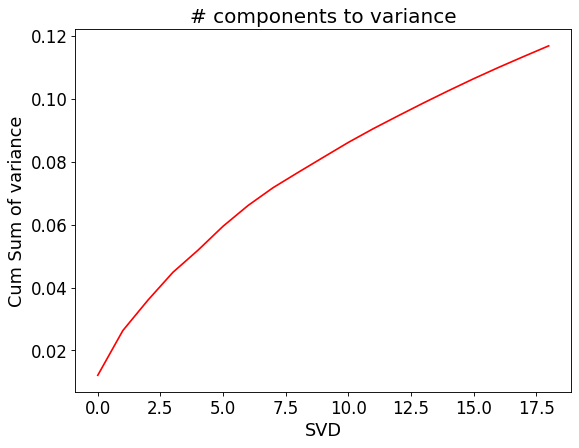

In [103]:
explained = svd.explained_variance_ratio_.cumsum()

plt.rcParams.update({'font.size': 15})
figure(figsize=(8, 6), dpi=80)

plt.title('# components to variance', fontsize=18)

plt.plot(explained, color = 'red')
plt.xlabel("SVD", fontsize=16)
plt.ylabel('Cum Sum of variance', fontsize=16)
plt.show()

In [104]:
latent_matrix_1_trimming = pd.DataFrame(latent_matrix, index = movies_trimmed.movieId)
latent_matrix_1_trimmed = latent_matrix_1_trimming.loc[movie_ratings.index]
latent_matrix_1_trimmed

latent_matrix_1_trimmed.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
movieId,,,,,,,,,,,,,,,,,,,
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.809588,-0.516813,-0.238044,0.006711,-0.177671,0.052825,-0.066467,-0.035954,-0.03034,-0.038843,0.001702,0.015395,0.006552,-0.080699,-0.004777,0.023781,0.018806,0.016061,-0.021932
18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [105]:
def recommend_similar_movies(title, method): # movie recommender code
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_content = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_content_trim = cosine_similarity(latent_matrix_1_trimmed, a_1).reshape(-1)
    score_collab = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # hybrid score: an average measure of both content and collaborative 
    hybrid_score = (score_content_trim + score_collab)/2
    
    if method == "hybrid":
        # form a data frame of similar movies 
        dictDF = {'hybrid': hybrid_score}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_2_df.index)

        #sort it on the basis of hybrid score
        similar_movies.sort_values('hybrid', ascending = False, inplace = True)
        print(similar_movies)
    
    if method == "content":
        dictDF = {'content': score_content}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_1_df.index)
        
        #sort it on the basis of content score
        similar_movies.sort_values('content', ascending = False, inplace = True)
        print(similar_movies)
    
    if method == "collab":
        dictDF = {'collab': score_collab}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_2_df.index)
        
        #sort it on the basis of collab score
        similar_movies.sort_values('collab', ascending = False, inplace = True)
        print(similar_movies)
    
    return None

### Examples

In [106]:
# Content Filtering
recommend_similar_movies("Naked Gun 2 1/2: The Smell of Fear, The (1991)", "content") 

                                                   content
Naked Gun 2 1/2: The Smell of Fear, The (1991)    1.000000
247°F (2011)                                      0.999751
Meek's Cutoff (2010)                              0.999747
Pygmalion (1938)                                  0.999720
Love Loves Coincidences (2011)                    0.999690
...                                                    ...
Bus 174 (Ônibus 174) (2002)                      -0.007869
V. I. Warshawski (1991)                          -0.007874
Shanghai Noon (2000)                             -0.008773
Grant Morrison: Talking with Gods (2010)         -0.008864
Seven Beauties (Pasqualino Settebellezze) (1976) -0.010376

[3818 rows x 1 columns]


In [107]:
# Collaborative Filtering
recommend_similar_movies("Dune (1984)", "collab") 

                                              collab
Dune (1984)                                 1.000000
Into the Blue (2005)                        0.890638
Broken Embraces (Los abrazos rotos) (2009)  0.883475
Under Suspicion (2000)                      0.857965
Square, The (Al Midan) (2013)               0.855422
...                                              ...
Blue Hawaii (1961)                         -0.287183
In the Heat of the Night (1967)            -0.291777
Long Riders, The (1980)                    -0.305361
Cocoon: The Return (1988)                  -0.325001
Kid, The (1921)                            -0.377304

[3818 rows x 1 columns]


# Matrix Factorization Recommender

In [108]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [109]:
R= np.array(ratings_trimmed.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [110]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 199.7833
Iteration: 40 ; error = 187.4066
Iteration: 60 ; error = 179.9357
Iteration: 80 ; error = 174.7047
Iteration: 100 ; error = 170.5110

P x Q:
[[3.47368496 3.70136682 3.39977058 ... 3.18288268 3.56118514 3.40431126]
 [3.96179734 4.20381812 3.9038164  ... 3.6897647  4.07954931 3.90688673]
 [4.18495872 4.43256342 4.13676236 ... 3.90153546 4.25497863 4.12115486]
 ...
 [3.4394398  3.69020982 3.38753707 ... 3.17151635 3.54681514 3.37907941]
 [4.05768094 4.29109452 3.99017587 ... 3.74599069 4.16229096 3.96878315]
 [3.31275723 3.55413318 3.24306089 ... 3.01139913 3.41619284 3.23523886]]



# Surprise


In [111]:
reader = Reader(rating_scale = (1,5))                                         # parse ratings
data = Dataset.load_from_df(ratings_trimmed[['userId', 'movieId', 'rating']], reader) # defining dataset

In [112]:
trainset, testset = train_test_split(data, test_size=0.25) # split data to train and test dataset

In [113]:
svd = SVD(verbose=True) # create svd model for matrix factorization

In [114]:
%%time
svd.fit(trainset) # train svd

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
CPU times: user 1.89 s, sys: 10.4 ms, total: 1.9 s
Wall time: 1.87 s


In [115]:
predictions = svd.test(testset) # get predictions of ratings in testset from svd

In [116]:
accuracy.rmse(predictions)

RMSE: 0.9338


0.9338368990721532

In [117]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_trimmed[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.9298


0.9298475896349936

In [118]:
# this will help us later on to id movie name with movie id
Mapping_file = dict(zip(movies_trimmed["title"].tolist(), movies_trimmed["movieId"].tolist()))

In [119]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_trimmed[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.9298


0.9297562095551446

In [120]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

### Examples

In [121]:
pred_user_rating(10)

,ratings
movies,
Louis C.K.: Chewed Up (2008),4.577080
State of Siege (État de siège) (1972),4.426146
"10th Kingdom, The (2000)",4.414951
Force of Evil (1948),4.409004
"Shawshank Redemption, The (1994)",4.406934
Laurence Anyways (2012),4.401309
X2: X-Men United (2003),4.372526
"Trou, Le (Hole, The) (Night Watch, The) (1960)",4.372409
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",4.367818


In [122]:
pred_user_rating(20)

,ratings
movies,
Pixote (1981),4.007490
Eternal Sunshine of the Spotless Mind (2004),3.967364
"Shawshank Redemption, The (1994)",3.950341
Cosmos (1980),3.923898
"Easy Life, The (Il Sorpasso) (1962)",3.913524
Radio Days (1987),3.898560
How to Train Your Dragon (2010),3.897803
Laurence Anyways (2012),3.885114
Munich (2005),3.884095
